## Initial HMM-ICA analysis

In [11]:
%matplotlib inline

from __future__ import print_function

import datetime
from dateutil.relativedelta import relativedelta

from pandas.plotting import autocorrelation_plot

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
import matplotlib as mpl
import seaborn as sns;

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy import stats
from itertools import permutations

from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
from sklearn.decomposition import FastICA, PCA
import matplotlib.patches as mpatches
from tabulate import tabulate

import os

#Fix to see latex path
os.environ["PATH"] ='/anaconda3/bin:/Users/rendarundle/anaconda/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin'

# use latex for font rendering
plt.rcParams['text.usetex'] = True

print(__doc__)

Automatically created module for IPython interactive environment


In [12]:
def sort_states(array):
    unique, counts = np.unique(array, return_counts=True)
    count2=pd.DataFrame(np.c_[unique, counts]).sort_values(by=[1],ascending=False)
    count2['counter'] = range(len(count2))
    dict_counts=count2['counter'].to_dict()    
#    newArray = np.copy(array)
#    for k, v in dict_counts.items(): newArray[array==k] = v
    return dict_counts #newArray

### Read data in and convert to numpy array

In [13]:
data = pd.read_excel("Long term data.xlsx", sheet_name="Timeseries", header=0)

data['Date'] = pd.to_datetime(data['Date'])
df = data.set_index(['Date'])
df=df.resample('M').last()
df=df.dropna()
df.columns=['IP', 'Unemployment','PPI','CPI','Wages','Bank rate','Prime rate','Bank deposit','Mortgate rate',
            '10-yr yield','Stocks','CB spreads','$/£','M1','Credit']
df_recent=df[df.index>'1959-12-31']
X=df_recent.values
an_list=['IP','PPI','Bank deposit','10-yr yield','Stocks','CB spreads','$/£','M1','Credit']
dates = mpl.dates.date2num(df_recent.index.to_pydatetime())
df_recent.describe()


,IP,Unemployment,PPI,CPI,Wages,Bank rate,Prime rate,Bank deposit,Mortgate rate,10-yr yield,Stocks,CB spreads,$/£,M1,Credit
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,6.840000e+02
mean,92.560884,6.261135,55.951256,49.161139,201.881759,6.956917,6.936666,4.789211,8.097642,7.678006,1335.012809,1.121778,1.931483,23391.546430,5.445556e+05
std,17.103491,2.694844,35.122299,31.426739,167.548834,4.058219,3.984970,3.341108,3.352046,3.574999,1223.855443,0.545864,0.468728,21140.888547,6.330626e+05
min,56.799336,1.984551,7.627828,6.565517,9.191783,0.250000,0.317700,0.400000,2.184300,0.712152,65.260000,-0.260000,1.093100,2340.617955,4.462808e+03
25%,78.875000,4.200000,15.222724,13.951724,29.598720,4.750000,4.563000,2.500000,5.975700,4.882451,166.865000,0.750000,1.571975,5193.217750,2.666871e+04
50%,98.400000,5.500000,59.573276,49.710345,167.396563,6.000000,6.280000,3.690000,7.625000,7.285000,994.940000,1.057174,1.750200,16097.195000,2.496802e+05
75%,107.675000,8.100000,84.400000,74.738000,346.000000,9.906250,9.810000,6.750000,11.000000,10.435000,2524.486186,1.430000,2.385000,36562.715000,9.123974e+05
max,117.200000,11.900000,108.900000,101.900000,509.000000,17.000000,17.700000,15.000000,15.451824,16.340000,3807.125296,4.108182,2.815000,80396.000000,1.908201e+06


### Get data to stationarity

In [14]:
df_recent_stationary=df_recent[an_list].copy()
log_list=['IP','PPI','Stocks','M1','Credit','$/£']
raw_list=['Bank deposit','10-yr yield','CB spreads']
df_recent_stationary[log_list]=np.log(df_recent_stationary[log_list]).diff(1)
# Need second difference for these series
df_recent_stationary[['Credit']]=df_recent_stationary[['Credit']].diff(1)
df_recent_stationary[raw_list]=df_recent_stationary[raw_list].diff(1)
df_recent_stationary.dropna(inplace=True)
# Finally, standardise the data
df_recent_stationary=(df_recent_stationary - df_recent_stationary.mean())/df_recent_stationary.std()
df_recent_stationary.describe()

,IP,PPI,Bank deposit,10-yr yield,Stocks,CB spreads,$/£,M1,Credit
count,6.820000e+02,6.820000e+02,6.820000e+02,6.820000e+02,6.820000e+02,6.820000e+02,6.820000e+02,6.820000e+02,6.820000e+02
mean,8.139465e-19,3.099915e-16,7.490343e-17,2.156958e-18,-2.873231e-17,-4.069732e-19,-1.546498e-18,3.092997e-17,1.627893e-19
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.351725e+00,-2.723444e+00,-4.543472e+00,-5.229613e+00,-6.020027e+00,-4.979065e+00,-5.012525e+00,-6.120535e+00,-5.793324e+00
25%,-3.954846e-01,-6.887797e-01,-4.766588e-02,-4.928198e-01,-4.546934e-01,-3.878185e-01,-4.779892e-01,-4.553522e-01,-4.613289e-01
50%,7.813080e-03,-2.667827e-01,6.939043e-03,4.743810e-02,7.052821e-02,-1.660344e-02,5.423056e-02,-4.617037e-02,1.772769e-02
75%,4.571767e-01,3.844284e-01,6.939043e-03,4.997568e-01,5.364353e-01,3.731868e-01,5.175629e-01,3.867749e-01,4.482068e-01
max,5.936011e+00,5.552234e+00,9.107760e+00,5.083253e+00,8.147578e+00,5.021366e+00,4.409399e+00,7.239349e+00,8.058275e+00


### Stationarity tests

Check for stationarity in the original series using:
1. Augmented Dicky Fuller Unit root test. Null hypothesis is that series has a unit root. 
2. Kwiatkowski-Phillips-Schmidt-Shin test for stationarity. Null hypothesis is that series is stationary.

In [15]:
# ADF test

for var in an_list:
    X = df_recent_stationary[var].values
    result = adfuller(X)
    print(var)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


IP
ADF Statistic: -36.698793
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
PPI
ADF Statistic: -2.910705
p-value: 0.044117
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Bank deposit
ADF Statistic: -21.378137
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
10-yr yield
ADF Statistic: -17.821939
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Stocks
ADF Statistic: -11.432042
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
CB spreads
ADF Statistic: -31.074260
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
$/£
ADF Statistic: -12.459801
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
M1
ADF Statistic: -3.372089
p-value: 0.011948
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Credit
ADF Statistic: -10.213827
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [16]:
# KPSS test for non-stationarity

for var in an_list:
    X = df_recent_stationary[var].values
    result = kpss(X)
    print(var)
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))


IP
KPSS Statistic: 0.352700
p-value: 0.097543
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
PPI
KPSS Statistic: 0.989206
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Bank deposit
KPSS Statistic: 0.074054
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
10-yr yield
KPSS Statistic: 0.331883
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Stocks
KPSS Statistic: 0.096635
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
CB spreads
KPSS Statistic: 0.020847
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
$/£
KPSS Statistic: 0.044784
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
M1
KPSS Statistic: 0.235312
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Credit
KPSS Statistic: 0.017447
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.4

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than 

### Hidden Markov Model on untransformed variables


In [17]:
np.set_printoptions(precision=4,suppress=True)


In [18]:
np.random.seed(8)
X = df_recent_stationary[an_list].values
ndim=X.shape[1]

print("fitting to HMM and decoding ...", end="")

print()
best_AIC=10000000000000
final_k=0
for k in range(2,10):
    # Make an HMM instance and execute fit
    # Repeat HMM modelling for 10 random_states and pick the best one
    tL=-1000000000000
    for t in range(0,20):
        r=np.random.randint(0,10000)
        model = GaussianHMM(n_components=k, covariance_type="diag", random_state=r, n_iter=1000).fit(X)
        if model.score(X)>tL:
            tL=model.score(X)
            tr=r
    # Run best model
    model = GaussianHMM(n_components=k, covariance_type="diag", random_state=tr, n_iter=1000).fit(X)
            
    L=model.score(X)
    npars = k-1 + k*(k-1) + k * ndim + k * ndim
    persistence=(model.n_components-np.diag(model.transmat_).sum())/model.n_components
    determinant=np.linalg.det(model.transmat_)
    AIC=2*npars-2*L
    print(k,L,AIC,persistence,determinant)
    if k==0:
        best_AIC=AIC
        fin_r=tr
    elif AIC < best_AIC:
        print("new LL")
        final_k=k
        best_AIC=AIC
        fin_r=tr

# Predict the optimal sequence of internal hidden state
print("Final k = " + str(final_k) + ", Final r =" + str(fin_r))
model_hmm = GaussianHMM(n_components=final_k, covariance_type="diag", n_iter=1000, random_state=fin_r).fit(X)
hidden_states_hmm = model_hmm.predict(X)

print("done")

fitting to HMM and decoding ...
2 -7447.881336768847 14973.762673537694 0.25995709083206986 0.4800858183358604
new LL
3 -6645.882307360608 13415.764614721216 0.32178592447925575 0.13233276063472887
new LL
4 -6462.437430346268 13098.874860692536 0.3905005680439724 0.03891308089917326
new LL
5 -6362.607915628731 12953.215831257461 0.46352924770332316 0.007821901636549033
new LL
6 -6252.119254573621 12790.238509147242 0.440337543546741 0.011113101468299604
new LL
7 -5975.474686161513 12298.949372323026 0.45981479207471265 0.0013154175597715806
new LL
8 -5852.348343118986 12118.696686237972 0.46863260242499793 4.79162078344209e-05
new LL
9 -5776.594463094346 12037.188926188692 0.4543967856148677 0.00011760817421308046
new LL
Final k = 9, Final r =4373
done


In [19]:
print("Transition matrix")
print(model_hmm.transmat_)
print()

print(tabulate(model_hmm.transmat_, tablefmt="latex", floatfmt=".2f"))

print("Means and vars of each hidden state")
for i in range(model_hmm.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model_hmm.means_[i])
    print("var = ", np.diag(model_hmm.covars_[i]))
    print()


Transition matrix
[[0.7776 0.     0.017  0.1961 0.     0.     0.     0.0093 0.    ]
 [0.     0.637  0.1739 0.     0.     0.0625 0.     0.1266 0.    ]
 [0.0086 0.     0.4346 0.053  0.3392 0.0456 0.0206 0.0981 0.0003]
 [0.6242 0.     0.     0.202  0.     0.0265 0.0213 0.0592 0.0667]
 [0.     0.     0.3992 0.     0.4823 0.0464 0.     0.     0.0721]
 [0.     0.168  0.1418 0.     0.0947 0.5631 0.     0.0324 0.    ]
 [0.     0.     0.0278 0.     0.     0.     0.8178 0.     0.1544]
 [0.     0.2966 0.2502 0.     0.     0.0986 0.     0.3221 0.0324]
 [0.     0.     0.0539 0.0115 0.     0.     0.2505 0.0104 0.6738]]

\begin{tabular}{rrrrrrrrr}
\hline
 0.78 & 0.00 & 0.02 & 0.20 & 0.00 & 0.00 & 0.00 & 0.01 & 0.00 \\
 0.00 & 0.64 & 0.17 & 0.00 & 0.00 & 0.06 & 0.00 & 0.13 & 0.00 \\
 0.01 & 0.00 & 0.43 & 0.05 & 0.34 & 0.05 & 0.02 & 0.10 & 0.00 \\
 0.62 & 0.00 & 0.00 & 0.20 & 0.00 & 0.03 & 0.02 & 0.06 & 0.07 \\
 0.00 & 0.00 & 0.40 & 0.00 & 0.48 & 0.05 & 0.00 & 0.00 & 0.07 \\
 0.00 & 0.17 & 0.14 & 0.00 

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  State 0 &  State 1 &  State 2 &  State 3 &  State 4 &  State 5 &  State 6 &  State 7 &  State 8 &  State 9 \\
\midrule
count    &   108.00 &    41.00 &   114.00 &    35.00 &    80.00 &    35.00 &   145.00 &    31.00 &    92.00 &      0.0 \\
mean     &    -0.01 &    -0.52 &     0.04 &    -0.16 &     0.35 &     0.36 &     0.02 &     0.01 &    -0.23 &      NaN \\
std      &     0.73 &     1.53 &     0.84 &     1.16 &     0.83 &     1.93 &     0.65 &     1.13 &     1.03 &      NaN \\
min      &    -2.04 &    -4.35 &    -2.05 &    -2.68 &    -2.07 &    -6.02 &    -2.74 &    -3.07 &    -4.81 &      NaN \\
50\%      &     0.14 &    -0.20 &     0.08 &    -0.18 &     0.39 &     0.30 &     0.08 &     0.23 &    -0.11 &      NaN \\
max      &     1.72 &     3.80 &     2.69 &     2.32 &     2.16 &     8.15 &     1.38 &     2.68 &     2.01 &      NaN \\
Kurtosis &     0.32 &     1.00 &     0.60 &     0.22 &     0.62 &    10.44 &     2.12 &     1.13 &     3

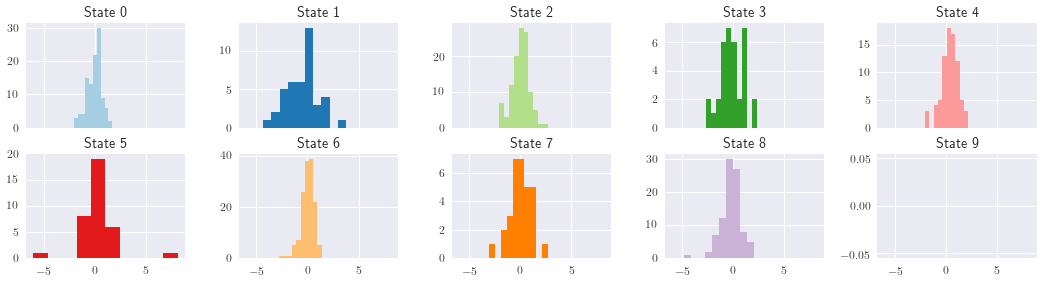

In [20]:
tempseries=df_recent_stationary['Stocks'].shift(-1)
sns.set(font_scale=1.2)
rows=2
if (model_hmm.n_components % rows) == 0:
    cols=int(model_hmm.n_components/rows)
else:
    cols=int(model_hmm.n_components/rows)+1
    
width=3*cols
fig, ax = plt.subplots(rows,cols,figsize=(width,4), sharex=True)
plt.tight_layout()
k=0
colours = cm.Paired(np.linspace(0, 1, 12))

colnames=[]
for i in range(0,rows):
    for j in range(0,cols):
        if k>model_hmm.n_components: break
        mask = hidden_states_hmm == k
        calc_data=df_recent_stationary[an_list].values[mask]
        df_stats=tempseries[mask].describe(percentiles=[0.5])
        kurt = tempseries[mask].kurtosis(skipna=True)
        skew = tempseries[mask].skew(skipna=True)
        df_stats=df_stats.append(pd.Series(kurt,index=['Kurtosis']))
        df_stats=df_stats.append(pd.Series(skew,index=['Skewness']))
        ax[i][j].set_title('State ' + str(k))
        tempseries[mask].hist(ax=ax[i][j],color=colours[k])

        if k == 0:
            df_returnstats = pd.DataFrame(df_stats)
        else:
            df_returnstats = df_returnstats.merge(pd.DataFrame(df_stats), left_index=True, right_index=True)
        colnames.append('State ' + str(k))
        k+=1

df_returnstats.columns=colnames
plt.savefig("../Upgrade new version/return_dist1.eps", dpi=300,bbox_inches='tight')

print(df_returnstats.to_latex(float_format='%.2f'))

### Hidden Markov Model on independent components

This assumes that the regime shift occurs due to shifts in the underlying system of independent components rather than due to the interaction between independent components.


#### Independent component analysis

First do the ICA on the untransformed variables

In [21]:
# Compute ICA
X = df_recent_stationary[an_list].values
ica = FastICA(n_components=9, algorithm='parallel',random_state=0,max_iter=2000, tol=0.00000001)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


In [22]:
df_ICA=pd.DataFrame(S_)
df_ICA.index=df_recent_stationary.index


In [23]:
np.random.seed(8)
X = df_ICA.values
ndim=X.shape[1]
print()
best_AIC=10000000000000
final_k=0
for k in range(2,10):
    # Make an HMM instance and execute fit

    tL=-1000000000000
    for t in range(0,20):
        r=np.random.randint(0,10000)
        model = GaussianHMM(n_components=k, covariance_type="diag", n_iter=1000, random_state=r).fit(X)
        if model.score(X)>tL:
            tL=model.score(X)
            tr=r
    # Run best model
    model = GaussianHMM(n_components=k, covariance_type="diag", random_state=tr, n_iter=1000).fit(X)

    L=model.score(X)
    npars = k-1 + k*(k-1) + k * ndim + k * ndim
    AIC=2*npars-2*L
    persistence=(model.n_components-np.diag(model.transmat_).sum())/model.n_components
    print(k,L,AIC, persistence)
    if k==0:
        best_AIC=AIC
        fin_r=tr
    elif AIC < best_AIC:
        print("new LL")
        final_k=k
        best_AIC=AIC
        fin_r=tr

# Predict the optimal sequence of internal hidden state
print("Final k = " + str(final_k))
model_ica = GaussianHMM(n_components=final_k, covariance_type="diag", n_iter=1000, random_state=fin_r).fit(X)
hidden_states_ica = model_ica.predict(X)

print("done")


2 12342.141875027452 -24606.283750054903 0.16701495041329162
new LL
3 12581.959605570371 -25039.919211140743 0.19692122998012143
new LL
4 12790.523494173665 -25407.04698834733 0.20943138833472397
new LL
5 12878.637278711314 -25529.27455742263 0.2307227898014806
new LL
6 12963.987527601023 -25641.975055202045 0.27498188827963393
new LL
7 13018.425384703634 -25688.85076940727 0.26273741736329853
new LL
8 13060.372129946054 -25706.744259892108 0.25301355424348915
new LL
9 13071.445970173545 -25658.89194034709 0.37852090450000236
Final k = 8
done


In [24]:
print("Transition matrix")
print(model_ica.transmat_)
print()

print(tabulate(model_ica.transmat_, tablefmt="latex", floatfmt=".2f"))


print("Means and vars of each hidden state")
for i in range(model_ica.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model_ica.means_[i])
    print("var = ", np.diag(model_ica.covars_[i]))
    print()


Transition matrix
[[0.5818 0.     0.2303 0.     0.     0.1879 0.     0.    ]
 [0.     0.8415 0.     0.     0.14   0.     0.0185 0.    ]
 [0.0133 0.     0.9061 0.     0.0062 0.0744 0.     0.    ]
 [0.     0.     0.     0.792  0.084  0.     0.124  0.    ]
 [0.     0.337  0.0538 0.0875 0.5217 0.     0.     0.    ]
 [0.0304 0.     0.1355 0.     0.     0.7923 0.0418 0.    ]
 [0.     0.0486 0.     0.0963 0.     0.1292 0.6784 0.0475]
 [0.     0.     0.     0.1379 0.     0.     0.     0.8621]]

\begin{tabular}{rrrrrrrr}
\hline
 0.58 & 0.00 & 0.23 & 0.00 & 0.00 & 0.19 & 0.00 & 0.00 \\
 0.00 & 0.84 & 0.00 & 0.00 & 0.14 & 0.00 & 0.02 & 0.00 \\
 0.01 & 0.00 & 0.91 & 0.00 & 0.01 & 0.07 & 0.00 & 0.00 \\
 0.00 & 0.00 & 0.00 & 0.79 & 0.08 & 0.00 & 0.12 & 0.00 \\
 0.00 & 0.34 & 0.05 & 0.09 & 0.52 & 0.00 & 0.00 & 0.00 \\
 0.03 & 0.00 & 0.14 & 0.00 & 0.00 & 0.79 & 0.04 & 0.00 \\
 0.00 & 0.05 & 0.00 & 0.10 & 0.00 & 0.13 & 0.68 & 0.05 \\
 0.00 & 0.00 & 0.00 & 0.14 & 0.00 & 0.00 & 0.00 & 0.86 \\
\hline
\end

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  State 0 &  State 1 &  State 2 &  State 3 &  State 4 &  State 5 &  State 6 &  State 7 \\
\midrule
count    &    16.00 &   122.00 &   256.00 &    49.00 &    46.00 &   134.00 &    42.00 &    16.00 \\
mean     &    -0.07 &    -0.00 &    -0.04 &     0.41 &     0.02 &     0.07 &     0.03 &    -1.23 \\
std      &     1.15 &     0.80 &     0.77 &     1.64 &     1.04 &     0.99 &     0.97 &     1.87 \\
min      &    -2.67 &    -2.68 &    -4.81 &    -2.54 &    -2.66 &    -6.02 &    -3.07 &    -4.35 \\
50\%      &    -0.01 &     0.16 &     0.05 &     0.17 &    -0.05 &     0.15 &     0.23 &    -1.38 \\
max      &     1.74 &     2.22 &     2.01 &     8.15 &     2.68 &     1.86 &     1.71 &     3.80 \\
Kurtosis &     0.67 &     0.64 &     6.11 &     9.38 &     0.80 &     9.73 &     1.35 &     2.52 \\
Skewness &    -0.51 &    -0.42 &    -1.48 &     2.09 &     0.02 &    -1.82 &    -1.00 &     1.03 \\
\bottomrule
\end{tabular}



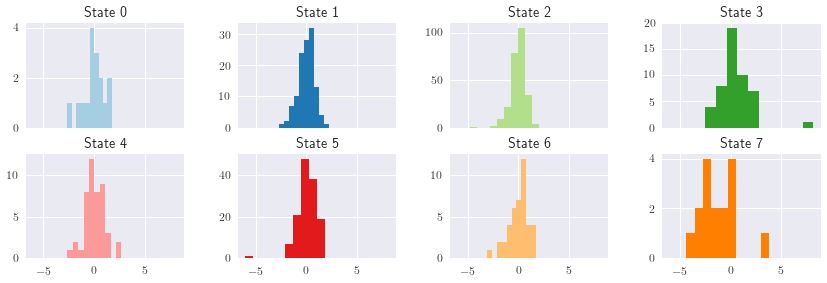

In [25]:
tempseries=df_recent_stationary['Stocks'].shift(-1)
sns.set(font_scale=1.2)
rows=2
if (model_ica.n_components % rows) == 0:
    cols=int(model_ica.n_components/rows)
else:
    cols=int(model_ica.n_components/rows)+1
width=3*cols
fig, ax = plt.subplots(rows,cols,figsize=(width,4), sharex=True)
plt.tight_layout()
k=0
colours = cm.Paired(np.linspace(0, 1, 12))

colnames=[]
for i in range(0,rows):
    for j in range(0,cols):
        if k>model_ica.n_components: break
        mask = hidden_states_ica == k
        calc_data=df_recent_stationary[an_list].values[mask]
        df_stats=tempseries[mask].describe(percentiles=[0.5])
        kurt = tempseries[mask].kurtosis(skipna=True)
        skew = tempseries[mask].skew(skipna=True)
        df_stats=df_stats.append(pd.Series(kurt,index=['Kurtosis']))
        df_stats=df_stats.append(pd.Series(skew,index=['Skewness']))
        ax[i][j].set_title('State ' + str(k))
        tempseries[mask].hist(ax=ax[i][j],color=colours[k])

        if k == 0:
            df_returnstats = pd.DataFrame(df_stats)
        else:
            df_returnstats = df_returnstats.merge(pd.DataFrame(df_stats), left_index=True, right_index=True)
        colnames.append('State ' + str(k))
        k+=1

df_returnstats.columns=colnames
plt.savefig("../Upgrade new version/return_dist2.eps", dpi=300,bbox_inches='tight')

print(df_returnstats.to_latex(float_format='%.2f'))

In [26]:
# Do KS-test on data in two regimes....

for i in range(0,model_ica.n_components):
    mask = hidden_states_ica == i
    calc_data=df_recent_stationary[an_list].values[mask]
    for j in range(1,model_ica.n_components):
        if i==j: break
        mask2=hidden_states_ica==j
        for var in an_list:
            data1=df_recent_stationary[var].values[mask]
            data2=df_recent_stationary[var].values[mask2]
            print("KS-test between regime " + str(i) + " and " + str(j) + " for variable " + var)
            print(stats.ks_2samp(data1, data2))
    
    vari=np.nanstd(calc_data,axis=0)
    meani=np.nanmean(calc_data,axis=0)
    v1=''.join(["Mean", str(i)])
    v2=''.join(["Std", str(i)])

    if i == 0:
        df_means = pd.DataFrame({v1:meani, v2:vari})
    else:
        df_means = df_means.merge(pd.DataFrame({v1:meani, v2:vari}), left_index=True, right_index=True)
    
df_means.index=an_list
print(df_means.T.to_latex(float_format='%.2f'))
#print(df_means.ix['Bank deposit'].T.to_latex(float_format='%.2f'))
problem=df_means.loc[['Bank deposit','10-yr yield']]
print(problem.to_latex(float_format='%.2f'))


KS-test between regime 0 and 1 for variable IP
Ks_2sampResult(statistic=0.33094262295081966, pvalue=0.07022336516116148)
KS-test between regime 0 and 1 for variable PPI
Ks_2sampResult(statistic=0.4293032786885246, pvalue=0.007135118524622221)
KS-test between regime 0 and 1 for variable Bank deposit
Ks_2sampResult(statistic=0.7141393442622951, pvalue=3.372865436098147e-07)
KS-test between regime 0 and 1 for variable 10-yr yield
Ks_2sampResult(statistic=0.48872950819672134, pvalue=0.0013454761023828717)
KS-test between regime 0 and 1 for variable Stocks
Ks_2sampResult(statistic=0.3094262295081967, pvalue=0.10700878748101017)
KS-test between regime 0 and 1 for variable CB spreads
Ks_2sampResult(statistic=0.2797131147540984, pvalue=0.18265564151143018)
KS-test between regime 0 and 1 for variable $/£
Ks_2sampResult(statistic=0.6219262295081968, pvalue=1.4594983401185716e-05)
KS-test between regime 0 and 1 for variable M1
Ks_2sampResult(statistic=0.25922131147540983, pvalue=0.255692445016641

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
{} &  Mean0 &  Std0 &  Mean1 &  Std1 &  Mean2 &  Std2 &  Mean3 &  Std3 &  Mean4 &  Std4 &  Mean5 &  Std5 &  Mean6 &  Std6 &  Mean7 &          Std7 \\
\midrule
Bank deposit &  -0.73 &  0.79 &  -0.06 &  0.28 &   0.01 &  0.15 &  -0.59 &  1.04 &   0.39 &  1.34 &  -0.22 &  0.70 &   1.40 &  2.81 &   0.01 &  1.734723e-18 \\
10-yr yield  &  -0.99 &  1.18 &   0.04 &  0.54 &  -0.09 &  0.53 &  -0.66 &  1.86 &   0.36 &  0.66 &   0.01 &  1.08 &   0.84 &  1.48 &   0.91 &  1.252958e+00 \\
\bottomrule
\end{tabular}



In [27]:
df_means.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, IP to Credit
Data columns (total 16 columns):
Mean0    9 non-null float64
Std0     9 non-null float64
Mean1    9 non-null float64
Std1     9 non-null float64
Mean2    9 non-null float64
Std2     9 non-null float64
Mean3    9 non-null float64
Std3     9 non-null float64
Mean4    9 non-null float64
Std4     9 non-null float64
Mean5    9 non-null float64
Std5     9 non-null float64
Mean6    9 non-null float64
Std6     9 non-null float64
Mean7    9 non-null float64
Std7     9 non-null float64
dtypes: float64(16)
memory usage: 1.5+ KB


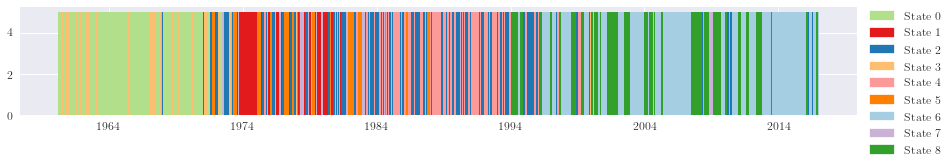

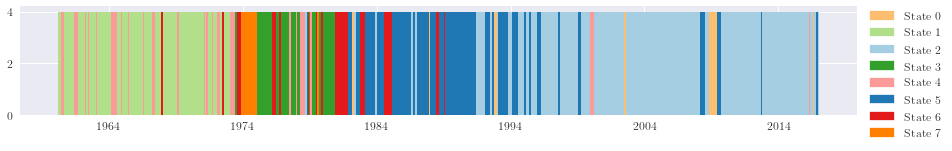

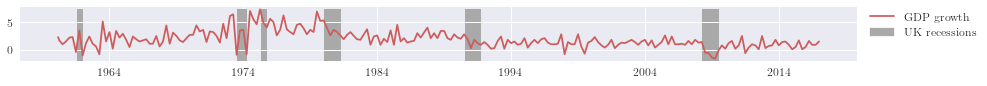

In [28]:
dataS = pd.read_excel("GDP.xls", sheet_name="data", header=0)
df_stocks = dataS.set_index(['Date'])
df_stocks=df_stocks.resample('M').interpolate(method='linear')
df_stocks=df_stocks[df_stocks.index>'1960-02-28']
dates = mpl.dates.date2num(df_recent_stationary.index.to_pydatetime())
sns.set(font_scale=1.2)

data_recession = pd.read_excel("UK recessions.xlsx", sheet_name="Sheet1", header=0)
df_recession = data_recession.set_index(['Date'])
df_recession=df_recession.resample('M').last()
df_recession=df_recession[df_recession.index>'1960-02-29']

patches_hmm = [None] * model_hmm.n_components
tvals = np.empty(dates.size)
tvals.fill(5)

colours = cm.Paired(np.linspace(0, 1, 12))

font = {'family':'serif', 'serif': ['Computer Modern Roman']}
plt.rc('font',**font)

fig, ax1 = plt.subplots(1,figsize=(15, 2))

for i in range(0,model_hmm.n_components):
    mask = hidden_states_hmm == i
    # get colour from dictionary 
    coli=sort_states(hidden_states_hmm).get(i)
    ax1.bar(dates[mask], tvals[mask], color = colours[coli], width=31)
    patches_hmm[i]=mpatches.Patch(color=colours[coli],label = "State %d" % i)
    ax1.xaxis_date()
#    ax1.set_yticklabels([])    
#    ax1.set_title('HMM only')

ax1.legend(handles=patches_hmm, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.savefig("../ICA_econ_paper/hmm.eps", dpi=300,bbox_inches='tight')

fig, ax2 = plt.subplots(1,figsize=(15, 2))

patches_ica = [None] * model_ica.n_components
tvals = np.empty(dates.size)
tvals.fill(4)
font = {'family':'serif', 'serif': ['Computer Modern Roman']}
plt.rc('font',**font)

for i in range(0,model_ica.n_components):
    mask = hidden_states_ica == i
    coli=sort_states(hidden_states_ica).get(i)
    ax2.bar(dates[mask], tvals[mask], color = colours[coli], width=31)
    patches_ica[i]=mpatches.Patch(color=colours[coli],label = "State %d" % i)
    ax2.xaxis_date()
#    ax2.set_yticks([])    
#    ax[1].set_title('HMM with ICA pre-processing')

ax2.legend(handles=patches_ica, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.savefig("../ICA_econ_paper/ica_hmm.eps", dpi=300,bbox_inches='tight')

fig, ax3 = plt.subplots(1,figsize=(15, 1))

tpatch=[None]*5
mask=df_recession['Dummy'].values==1
ax3.bar(dates[mask],tvals[mask],color='darkgrey', width=31)
tpatch=mpatches.Patch(color='darkgrey', label = 'UK recessions')
ax3.yaxis.tick_right() 
ax3.get_yaxis().set_visible(False)
ax3.legend(handles=[tpatch],bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0.)


ax4=ax3.twinx()
ax4.yaxis.tick_left() 

ax4.plot(df_stocks,color='indianred',label='GDP growth')
ax4.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.savefig("../ICA_econ_paper/gdp.eps", dpi=300,bbox_inches='tight')


In [29]:
err_hmm=(np.diag(model_hmm.transmat_).sum())/model_hmm.n_components
err_ica=(np.diag(model_ica.transmat_).sum())/model_ica.n_components
print(err_hmm,err_ica)

0.5456032143851323 0.7469864457565109


In [ ]:
for i in range(0,model.n_components):
    mask = hidden_states_ica == i
    calc_data=df_recent[an_list].values[mask]
    vari=np.nanstd(calc_data,axis=0)
    meani=np.nanmean(calc_data,axis=0)
    v1=''.join(["Mean", str(i)])
    v2=''.join(["Standard deviation", str(i)])

    if i == 0:
        df_means = pd.DataFrame({v1:meani, v2:vari})
    else:
        df_means = df_means.merge(pd.DataFrame({v1:meani, v2:vari}), left_index=True, right_index=True)
    
df_means.index=an_list
df_means=df_means*100
print(df_means.to_latex(float_format='%.2f'))


In [ ]:
tempseries=df_recent['Stocks'].shift(-1)*100
#sns.set(font_scale=1.2)

fig, ax = plt.subplots(2,1,figsize=(7,4), sharex=True)
plt.tight_layout()

for i in range(0,model.n_components):
    mask = hidden_states == i
    calc_data=df_recent[an_list].values[mask]
    df_stats=tempseries[mask].describe(percentiles=[0.5])
    kurt = tempseries[mask].kurtosis(skipna=True)
    skew = tempseries[mask].skew(skipna=True)
    df_stats=df_stats.append(pd.Series(kurt,index=['Kurtosis']))
    df_stats=df_stats.append(pd.Series(skew,index=['Skewness']))
    ax[i].set_title('State ' + str(i))
    tempseries[mask].hist(ax=ax[i],color=colours[i])

    if i == 0:
        df_returnstats = pd.DataFrame(df_stats)
    else:
        df_returnstats = df_returnstats.merge(pd.DataFrame(df_stats), left_index=True, right_index=True)


df_returnstats.columns=['State 0','State 1']
plt.savefig("../Upgrade new version/return_dist2.eps", dpi=300,bbox_inches='tight')

print(df_returnstats.to_latex(float_format='%.2f'))

In [ ]:
k=0
dates = mpl.dates.date2num(df_recent.index.to_pydatetime())

for var in df_ICA:
    
    fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True,figsize=(15, 2*model.n_components))
    fig.suptitle(var, fontsize=16)
    colours = cm.Paired(np.linspace(0, 1, 12))
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        # Use fancy indexing to plot data in each state.
        mask = hidden_states == i
        ax.plot_date(dates[mask], df_ICA[var].values[mask], ".-", c=colour)
        ax.text(1.05, 1,'Mean = %.3f' % model.means_[i,k], horizontalalignment='center', 
             verticalalignment='center',
             transform=ax.transAxes)
        ax.text(1.06, 0.8,'Variance = %.3f' % np.diag(model.covars_[i])[k], horizontalalignment='center', 
             verticalalignment='center',
             transform=ax.transAxes)

        ax.set_title("{0}th hidden state".format(i))

        # Format the ticks.
        ax.xaxis.set_major_locator(YearLocator())

    #    ax.xaxis.set_minor_locator(MonthLocator())

        ax.grid(True)

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
    k+=1

In [ ]:
fig, ax = plt.subplots(X.shape[1],figsize=(15, 26))

for signal in range(0,X.shape[1]):
    print("fitting to HMM and decoding ...", end="")

    # Make an HMM instance and execute fit
    model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=5000,random_state=7,).fit(X[:,signal].reshape(-1,1))

    # Predict the optimal sequence of internal hidden state
    hidden_states = model.predict(X[:,signal].reshape(-1,1))
    
    patches = [None] * model.n_components
    xvals = np.linspace(0, 8, X.shape[0])
    tvals = np.empty(X.shape[0])
    tvals.fill(5)
    labs = np.linspace(0,X.shape[0],X.shape[0])
    for i in range(0,model.n_components):
        mask = hidden_states == i
        ax[signal].bar(labs[mask], tvals[mask], color = colours[i], width=1)
        patches[i]=mpatches.Patch(color=colours[i],label = "State %d" % i)
    

    ax[signal].legend(handles=patches, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
plt.show()

### Growing and moving window asset allocator

In this section, I first use a growing window approach with the following algorithm:
1. Determine ICAs using data up to December 1989 (start of Total return data from WRDS)
2. Do initial training of ICAs and HMM
3. Calculate average return for each regime
4. Determine latest regime: if this regime had historically the highest return - invest, otherwise 0
5. Grow window by one month and repeat

The moving window approach works the same, but instead moves the window forward, so the amount of training history remains the same

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Growing window

# Read return data in

data_returns = pd.read_excel("FTSE100 Total returns.xlsx", sheet_name="WRDS", header=0)
data_returns['Date'] = pd.to_datetime(data_returns['Date'])
df_returns = data_returns.set_index(['Date'])
df_returns=df_returns.resample('M').last()
df_returns=df_returns.dropna()

# Select data

panelcount=0
ldate=df.index[-1]
asset_allocator=pd.DataFrame(index=df_returns.index.copy(),columns=['Return','Assumed Regime'])

for date in df_returns.index:

    index = date
    
    if (date > ldate):
        input("Press any key to continue > ")
        break

    df_train = df[(df.index<date)][an_list].copy()
    print ('Number of months in data set ' + str(df_train.shape[0]))
    trainX=df_train.values
    next_return=df_returns.loc[date]['Total return']

    pca = PCA(n_components=len(an_list), svd_solver='full', whiten=True)
    PCAS_ = pca.fit_transform(trainX)  # Reconstruct signals

    # Determine how many components to extract....

    totvar = 0
    icomp=0
    while totvar<0.999:
        totvar+=pca.explained_variance_ratio_[icomp]
        icomp+=1

    print ('Number of components to extract: ' + str(icomp))

    # Now run ICA on number of components

    ica = FastICA(n_components=icomp, algorithm='parallel', random_state=0, max_iter=2000, tol=0.00000001)
    S_ = ica.fit_transform(trainX)  # Reconstruct signals

    print("fitting to HMM and decoding ...", end="")

    # Make an HMM instance and execute fit
    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000,random_state=5).fit(S_)

    # Predict the optimal sequence of internal hidden state
    hidden_states = model.predict(S_)

    latest_reg=hidden_states[-1]
    print('Latest regime ' + str(latest_reg))

    tempdf = df_train[['Stocks']].copy()
    tempdf=tempdf.assign(Regime=pd.Series(hidden_states,index=tempdf.index))
    tempsts=tempdf.groupby(['Regime'])['Stocks'].mean()
    maxret=tempsts.max()
    curregav=tempsts.loc[latest_reg]
    
    if maxret==curregav:
        asset_allocator.loc[date]['Return']=next_return
    else:
        asset_allocator.loc[date]['Return']=0
        
    asset_allocator.loc[date]['Assumed Regime']=latest_reg   
    
asset_allocator=asset_allocator.dropna()
asset_allocator.loc[max(asset_allocator.index)+ relativedelta(months=+1), :] = None
t_piv=asset_allocator.shift(periods=1, freq=None, axis=0)+1
t_piv.fillna(1,inplace=True)
t_piv.iloc[0,:]=1
test_return=pd.DataFrame(t_piv['Return'].cumprod(axis=0))
print(test_return.tail(2))

In [ ]:
# Moving window

# Select data

ldate=df.index[-1]
asset_allocator_mw=pd.DataFrame(index=df_returns.index.copy(),columns=['Return','Assumed Regime'])
sdate=df.index[0]

for date in df_returns.index:

    index = date
    
    if (date > ldate):
        input("Press any key to continue > ")
        break

    df_train = df[(df.index>=sdate) & (df.index<date)][an_list].copy()
    print ('Number of months in data set ' + str(df_train.shape[0]))

    trainX=df_train.values
    next_return=df_returns.loc[date]['Total return']

    pca = PCA(n_components=len(an_list), svd_solver='full', whiten=True)
    PCAS_ = pca.fit_transform(trainX)  # Reconstruct signals

    # Determine how many components to extract....

    totvar = 0
    icomp=0
    while totvar<0.999:
        totvar+=pca.explained_variance_ratio_[icomp]
        icomp+=1

    print ('Number of components to extract: ' + str(icomp))

    # Now run ICA on number of components

    ica = FastICA(n_components=icomp, algorithm='parallel', random_state=0, max_iter=2000, tol=0.00000001)
    S_ = ica.fit_transform(trainX)  # Reconstruct signals

    print("fitting to HMM and decoding ...", end="")

    # Make an HMM instance and execute fit
    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000,random_state=5).fit(S_)

    # Predict the optimal sequence of internal hidden state
    hidden_states = model.predict(S_)

    latest_reg=hidden_states[-1]
    print('Latest regime ' + str(latest_reg))

    tempdf = df_train[['Stocks']].copy()
    tempdf=tempdf.assign(Regime=pd.Series(hidden_states,index=tempdf.index))
    tempsts=tempdf.groupby(['Regime'])['Stocks'].mean()
    maxret=tempsts.max()
    curregav=tempsts.loc[latest_reg]
    
    if maxret==curregav:
        asset_allocator_mw.loc[date]['Return']=next_return
    else:
        asset_allocator_mw.loc[date]['Return']=0
        
    asset_allocator_mw.loc[date]['Assumed Regime']=latest_reg
    sdate=sdate+relativedelta(months=+1)
    
asset_allocator_mw=asset_allocator_mw.dropna()
asset_allocator_mw.loc[max(asset_allocator_mw.index)+ relativedelta(months=+1), :] = None
t_piv=asset_allocator_mw.shift(periods=1, freq=None, axis=0)+1
t_piv.fillna(1,inplace=True)
t_piv.iloc[0,:]=1
test_return['Moving window']=t_piv['Return'].cumprod(axis=0)

treturns=df_returns[(df_returns.index<=ldate)].copy()
treturns.loc[max(treturns.index)+ relativedelta(months=+1), :] = None
t_piv=treturns.shift(periods=1, freq=None, axis=0)+1
t_piv.fillna(1,inplace=True)
t_piv.iloc[0,:]=1
test_return['Benchmark']=t_piv['Total return'].cumprod(axis=0).values
print(test_return.tail(2))


### Vector autoregression - no regime shift

The next step was to run a vector autoregression without any regime shifts. This will provide the 'base' case scenario to compare model fit.


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

In [ ]:
model = VAR(df_recent[an_list]) # Create the VAR model


In [ ]:
model.select_order(15).summary()


In [ ]:
results = model.fit(maxlags=15, ic='aic')

In [ ]:
results.summary()

In [ ]:
df_recent['$/£'].plot()